In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd /content/gdrive/MyDrive/MVA/Altegrad/Kaggle2

Mounted at /content/gdrive
/content/gdrive/MyDrive/MVA/Altegrad/Kaggle2


In [2]:
# Install required packages.
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

!pip install dgl 
!pip install gensim
!pip install node2vec

     |████████████████████████████████| 7.9 MB 9.6 MB/s 
     |████████████████████████████████| 3.5 MB 7.1 MB/s 
     |████████████████████████████████| 2.3 MB 9.1 MB/s 
     |████████████████████████████████| 145 kB 7.9 MB/s 
     |████████████████████████████████| 112 kB 67.0 MB/s 
     |████████████████████████████████| 74 kB 4.3 MB/s 
     |████████████████████████████████| 596 kB 71.7 MB/s 
     |████████████████████████████████| 4.4 MB 8.3 MB/s 
  Created wheel for node2vec: filename=node2vec-0.4.3-py3-none-any.whl size=5980 sha256=cb3b0fdf470c30e3aacc1eec5b64f9bcfa1ff5b12c93cda431c4d1c328d21e8e
  Stored in directory: /root/.cache/pip/wheels/07/62/78/5202cb8c03cbf1593b48a8a442fca8ceec2a8c80e22318bae9
Successfully built node2vec


In [3]:
import pandas as pd
import networkx as nx
import csv
import numpy as np
from random import randint
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import scipy.sparse as sp
from tqdm import tqdm

from torch_geometric.utils.convert import from_networkx
#from torch_geometric.nn import Node2Vec


from preprocessing import read_graph, retrieve_subgraph
from gensim.models.doc2vec import Doc2Vec

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


Using backend: pytorch


In [33]:
import matplotlib.pyplot as plt 

## Constructing Authors Graph : 

In [99]:
G, abstracts, text_per_author, author_per_text = read_graph()

Number of nodes: 138499
Number of edges: 1091955
Number of authors : 174961


In [100]:
def create_author_graph(text_per_author, author_per_text):
  G_authors = nx.Graph()
  for author in text_per_author.keys(): 
    G_authors.add_node(author)

  for text in author_per_text.keys(): 
    for aut1 in author_per_text[text]: 
      for aut2 in author_per_text[text]: 
        if aut1 != aut2 : 
          #if G_authors.has_edge(aut1, aut2):
          if G_authors.has_edge(aut1, aut2) == False : 
            G_authors.add_edge(aut1, aut2, weight = 1/2)
          else : 
            G_authors[aut1][aut2]['weight']+=1/2
  return G_authors

In [101]:
G_authors = create_author_graph(text_per_author, author_per_text)

In [102]:
degree_sequence = np.array([G_authors.degree(node) for node in G_authors.nodes()])
min_nb_nodes = 0
print('The minimum degree of the nodes in the graph is :', min(degree_sequence))
print('The maximum degree of the nodes in the graph is :', max(degree_sequence))
print('The mean degree of the nodes in the graph is :', np.mean(degree_sequence))
print('The median degree of the nodes in the graph is :', np.median(degree_sequence))

The minimum degree of the nodes in the graph is : 0
The maximum degree of the nodes in the graph is : 677
The mean degree of the nodes in the graph is : 6.504683900983648
The median degree of the nodes in the graph is : 4.0


In [103]:
for i, node in enumerate(G_authors.nodes()):
    G_authors.nodes[str(node)]['id'] = i
G_authors_train = from_networkx(G_authors) # already undirected

In [104]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(G_authors_train.edge_index, embedding_dim= 64, walk_length=30,
                    context_size=10, walks_per_node=20,
                    num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [105]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# @torch.no_grad()
# def test():
#     model.eval()
#     z = model()
#     acc = model.test(z[G_authors.train_mask], G_authors.y[G_authors.train_mask],
#                         z[G_authors.test_mask], G_authors.y[G_authors.test_mask],
#                         max_iter=150)
#     return acc

In [106]:
losses = []
for epoch in range(1, 20):
    loss = train()
    losses.append(loss)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 01, Loss: 1.8289
Epoch: 02, Loss: 0.8922
Epoch: 03, Loss: 0.8455
Epoch: 04, Loss: 0.8295
Epoch: 05, Loss: 0.8209
Epoch: 06, Loss: 0.8156
Epoch: 07, Loss: 0.8122
Epoch: 08, Loss: 0.8099
Epoch: 09, Loss: 0.8085
Epoch: 10, Loss: 0.8076
Epoch: 11, Loss: 0.8071
Epoch: 12, Loss: 0.8067
Epoch: 13, Loss: 0.8066
Epoch: 14, Loss: 0.8065
Epoch: 15, Loss: 0.8064
Epoch: 16, Loss: 0.8065
Epoch: 17, Loss: 0.8063
Epoch: 18, Loss: 0.8063
Epoch: 19, Loss: 0.8062


KeyboardInterrupt: ignored

In [107]:
torch.save(model.state_dict(), 'node2vec_authors_64dim')

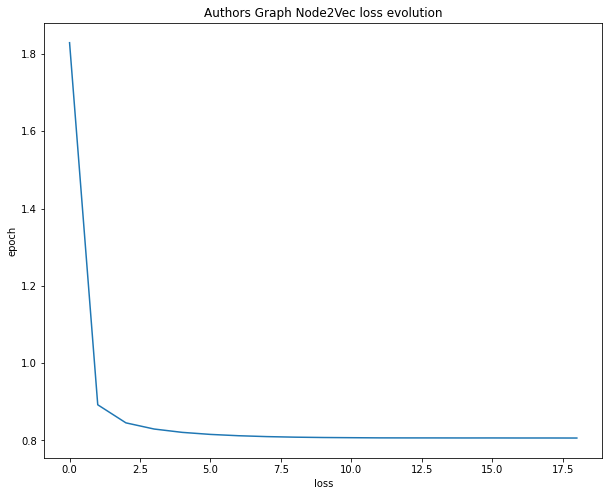

In [108]:
plt.figure(figsize = (10,8))
plt.plot(losses)
plt.title('Authors Graph Node2Vec loss evolution')
plt.xlabel('loss')
plt.ylabel('epoch')
plt.show()

In [109]:
model.load_state_dict(torch.load('node2vec_authors_64dim'))
model.eval()

Node2Vec(174961, 64)

In [112]:
authors_embedding = model(torch.arange(G_authors_train.num_nodes, device=device))

Creating features for each node :  each node is characterized by the average vector over the embedding of the authors of the node article. 

In [116]:
for text in author_per_text.keys(): 
  avg_authors_feature = torch.zeros([64]).to(device)
  for author in author_per_text[text]: 
    avg_authors_feature += authors_embedding[int(G_authors.nodes[str(author)]['id'])].to(device)
  avg_authors_feature /= len(author_per_text[text])
  G.nodes[text]['avg_authors_feature'] = avg_authors_feature ## Here : we add the features to the author features to the original graph (for link prediction)

In [132]:
print(G_authors['James H. Niblock'])
id1 = G_authors.nodes['James H. Niblock']['id']

print(G_authors['Jian-Xun Peng'])
id2 = G_authors.nodes['Jian-Xun Peng']['id']

print(G_authors['Karen Rafferty'])
id3 = G_authors.nodes['Karen Rafferty']['id']

{'Jian-Xun Peng': {'weight': 1.0}, 'Karen R. McMenemy': {'weight': 1.0}, 'George W. Irwin\n': {'weight': 1.0}}
{'James H. Niblock': {'weight': 1.0}, 'Karen R. McMenemy': {'weight': 1.0}, 'George W. Irwin\n': {'weight': 1.0}, 'Kang Li': {'weight': 2.0}, 'De-Shuang Huang\n': {'weight': 1.0}, 'G.W. Irwin\n': {'weight': 1.0}, 'Karen Rafferty': {'weight': 4.0}, 'Stuart Ferguson\n': {'weight': 2.0}, 'Stuart Ferguson': {'weight': 2.0}, 'Paul D. Kelly\n': {'weight': 1.0}, 'Victoria Stewart\n': {'weight': 1.0}}
{'Jian-Xun Peng': {'weight': 4.0}, 'Stuart Ferguson\n': {'weight': 2.0}, 'Stuart Ferguson': {'weight': 2.0}, 'Paul D. Kelly\n': {'weight': 1.0}, 'Victoria Stewart\n': {'weight': 1.0}, 'Shyama Prosad Chowdhury': {'weight': 1.0}, 'Amit Kumar Das\n': {'weight': 1.0}}


In [110]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

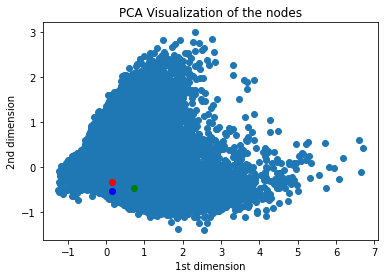

In [188]:
embeddings_2d = PCA(n_components=2).fit_transform(authors_embedding.cpu().detach().numpy())

# Visualizes the nodes
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1])
plt.scatter(embeddings_2d[id1,0], embeddings_2d[id1,1], c='r')
plt.scatter(embeddings_2d[id2, 0], embeddings_2d[id2,1], c='g')
plt.scatter(embeddings_2d[id3,0], embeddings_2d[id3,1], c='b')

plt.title('PCA Visualization of the nodes')
plt.xlabel('1st dimension')
plt.ylabel('2nd dimension')
plt.show()

## Second approach : Article nodes linked by number of commun authors

In [138]:
G, abstracts, text_per_author, author_per_text = read_graph()

Number of nodes: 138499
Number of edges: 1091955
Number of authors : 174961


In [158]:
def create_commun_authors_papers_graph(text_per_author, author_per_text):

  G_papers_ca = nx.Graph()
  for node in author_per_text.keys(): 
    G_papers_ca.add_node(node)

  for author in text_per_author.keys(): 
    for text1 in text_per_author[author]: 
        for text2 in text_per_author[author]: 
          if text1 != text2 : 
            if G_papers_ca.has_edge(text1, text2) == False : 
              G_papers_ca.add_edge(text1, text2, weight = 1/2)
            else : 
              G_papers_ca[text1][text2]['weight']+= 1/2
  return G_papers_ca

In [159]:
G_papers_ca = create_commun_authors_papers_graph(text_per_author, author_per_text)

In [160]:
degree_sequence = np.array([G_papers_ca.degree(node) for node in G_papers_ca.nodes()])
min_nb_nodes = 0
print('The minimum degree of the nodes in the graph is :', min(degree_sequence))
print('The maximum degree of the nodes in the graph is :', max(degree_sequence))
print('The mean degree of the nodes in the graph is :', np.mean(degree_sequence))
print('The median degree of the nodes in the graph is :', np.median(degree_sequence))

The minimum degree of the nodes in the graph is : 0
The maximum degree of the nodes in the graph is : 1344
The mean degree of the nodes in the graph is : 37.1137120123611
The median degree of the nodes in the graph is : 17.0


In [161]:
G_papers_ca = from_networkx(G_papers_ca) # already undirected

In [162]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(G_papers_ca.edge_index, embedding_dim= 64, walk_length=30,
                    context_size=10, walks_per_node=20,
                    num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [163]:
losses = []
for epoch in range(1, 20):
    loss = train()
    losses.append(loss)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 01, Loss: 1.8342
Epoch: 02, Loss: 0.9134
Epoch: 03, Loss: 0.8696
Epoch: 04, Loss: 0.8597
Epoch: 05, Loss: 0.8560
Epoch: 06, Loss: 0.8538
Epoch: 07, Loss: 0.8525
Epoch: 08, Loss: 0.8517
Epoch: 09, Loss: 0.8510
Epoch: 10, Loss: 0.8504
Epoch: 11, Loss: 0.8501
Epoch: 12, Loss: 0.8499
Epoch: 13, Loss: 0.8497
Epoch: 14, Loss: 0.8497
Epoch: 15, Loss: 0.8494
Epoch: 16, Loss: 0.8495
Epoch: 17, Loss: 0.8493
Epoch: 18, Loss: 0.8493
Epoch: 19, Loss: 0.8493


In [164]:
torch.save(model.state_dict(), 'node2vec_papers_ca_64dim')

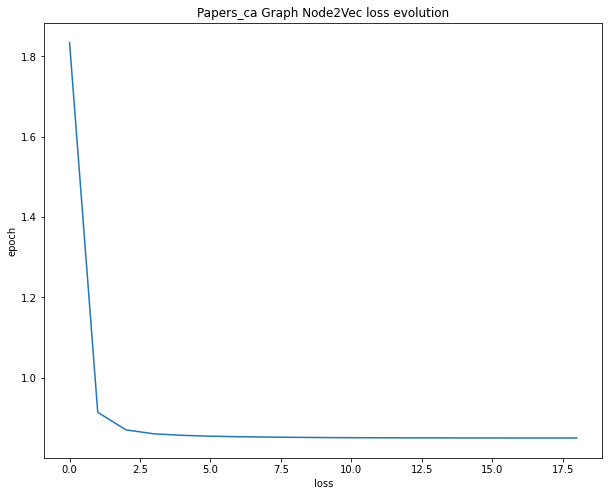

In [166]:
plt.figure(figsize = (10,8))
plt.plot(losses)
plt.title('Papers_ca Graph Node2Vec loss evolution')
plt.xlabel('loss')
plt.ylabel('epoch')
plt.show()

In [180]:
model.load_state_dict(torch.load('node2vec_papers_ca_64dim'))
model.eval()

Node2Vec(138499, 64)

In [181]:
papers_ca_embedding = model(torch.arange(G_papers_ca.num_nodes, device=device))

In [182]:
for node in author_per_text : 
  G.nodes[node]['feat_com_authors'] = papers_ca_embedding[node]

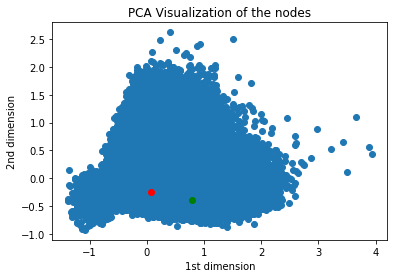

In [187]:
embeddings_2d = PCA(n_components=2).fit_transform(papers_ca_embedding.cpu().detach().numpy())

# Visualizes the nodes
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1])
plt.scatter(embeddings_2d[0,0], embeddings_2d[0,1], c='r')
plt.scatter(embeddings_2d[1, 0], embeddings_2d[1,1], c='g')

plt.title('PCA Visualization of the nodes')
plt.xlabel('1st dimension')
plt.ylabel('2nd dimension')
plt.show()

- TODO : validate the embeddings on a valset / using visualization methods 

In [ ]:
from torch_geometric.transforms import RandomLinkSplit
transform = RandomLinkSplit(is_undirected=True, num_val = 0.1, num_test = 0)
G_authors_train, G_authors_val, G_authors_test = transform(G_papers_ca)